In [3]:
import numpy as np

In [2]:
def generate_n_body_initial_conditions(n, seed=42, xlim=(-1, 1), ylim=(-1, 1), vlim=(0, 0.5)):
    np.random.seed(seed)
    x = np.random.uniform(*xlim, size=n)
    y = np.zeros(n)
    #y = np.random.uniform(*ylim, size=n)
    #Vx = np.random.uniform(*vlim, size=n)
    Vx = np.zeros(n)
    Vy = np.random.uniform(*vlim, size=n)
    return np.column_stack((x, y, Vx, Vy))

In [4]:
c = 3e8 # скорость света
#G = 6.6e-11
G = 39.478  # Гравитационная постоянная в AU^3 / (Масса_Солнца * год^2)

In [ ]:
n = 50
masses = 1e9 * np.ones(n)
seed = 42
initial_conditions = generate_n_body_initial_conditions(n, seed)

# Решение системы
t, trajectories = solve_n_body(n, masses, initial_conditions,t_max=1)

# Пример вывода координат первого тела
for i in range(n):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1])

#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Траектории движения тел")
plt.show()

# Solar System initial conditions

In [4]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

G = 39.478  # Гравитационная постоянная в AU^3 / (Масса_Солнца * год^2)

# Массы (в массах Солнца) и радиусы орбит (в а.е.), скорости (в а.е/год)
bodies = {
    "Sun":      (1.0, 0.0, 0.0),
    "Mercury":  (1.65e-7, 0.39, 10.1),
    "Venus":    (2.45e-6, 0.72, 7.4),
    "Earth":    (3.00e-6, 1.00, 6.3),
    "Mars":     (3.2e-7, 1.52, 5.1),
    "Jupiter":  (9.55e-4, 5.20, 2.7),
    "Saturn":   (2.86e-4, 9.58, 2.0),
    "Uranus":   (4.37e-5, 19.22, 1.4),
    "Neptune":  (5.15e-5, 30.05, 1.1),
    #"Pluto":    (6.5e-9, 40.05, 0.945),
}

# Количество тел
n = len(bodies)
T_max = 200
dT = 0.01

# Формируем массив масс и начальные условия
masses = np.array([bodies[planet][0] for planet in bodies])

# Начальные условия: (x, y, Vx, Vy)
initial_conditions = []
for i, (planet, (mass, r, V)) in enumerate(bodies.items()):
    x = r
    y = 0
    Vx = 0
    Vy = V #np.sqrt(G * masses[0] / r) if planet != "Sun" else 0  # Только планеты имеют орбитальную скорость
    initial_conditions.append([x, y, Vx, Vy])

initial_conditions = np.array(initial_conditions)

# Solar System with odeint

In [11]:
def n_body_equations(state, t, n, masses):
    """Функция для odeint, описывающая уравнения движения n тел."""
    state = state.reshape(n, 4)
    derivatives = np.zeros_like(state)

    n = len(state)
    # Позиции и скорости
    pos = state[:, :2]   # (n, 2)
    vel = state[:, 2:]   # (n, 2)

    # Заполняем производные скоростей (dx/dt = vx, dy/dt = vy)
    derivatives[:, :2] = vel

    # Расчёт ускорений
    for i in range(n):
        r_i = pos[i]  # (2,)
        diff = pos - r_i  # (n, 2)
        dist = np.linalg.norm(diff, axis=1) + 1e-5  # (n,)
        
        # Удаляем вклад тела i в суммирование
        mask = np.arange(n) != i
        diff = diff[mask]             # (n-1, 2)
        dist = dist[mask]             # (n-1,)
        m = masses[mask]              # (n-1,)

        # Ускорение: G * m / r^3 * dr
        accel = (G * m / dist**3)[:, np.newaxis] * diff  # (n-1, 2)
        total_accel = np.sum(accel, axis=0)

        derivatives[i, 2:] = total_accel

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=50, dt=dT):
    """Решает задачу n тел и возвращает траектории."""
    t = np.arange(0, t_max, dt)
    sol = odeint(n_body_equations, initial_conditions.flatten(), t, args=(n, masses))
    return t, sol.reshape(-1, n, 4)

# Решение системы
t, trajectories = solve_n_body(n, masses, initial_conditions,t_max=200)

# Solar System with solve_ivp

In [20]:
def n_body_equations(t, y, n, masses):
    state = y.reshape(n, 4)
    derivatives = np.zeros_like(state)

    pos = state[:, :2]
    vel = state[:, 2:]

    derivatives[:, :2] = vel

    for i in range(n):
        r_i = pos[i]
        diff = pos - r_i
        dist = np.linalg.norm(diff, axis=1) + 1e-5

        mask = np.arange(n) != i
        diff = diff[mask]
        dist = dist[mask]
        m = masses[mask]

        accel = (G * m / dist**3)[:, np.newaxis] * diff
        derivatives[i, 2:] = np.sum(accel, axis=0)

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=50, dt=0.01):
    """Решает задачу n тел и возвращает траектории, используя solve_ivp."""
    t_span = (0, t_max)
    t_eval = np.arange(0, t_max, dt)
    y0 = initial_conditions.flatten()
    sol = solve_ivp(
        n_body_equations,
        t_span,
        y0,
        args=(n, masses),
        t_eval=t_eval,
        method='DOP853',
        rtol=1e-9,
        atol=1e-9
    )
    return sol.t, sol.y.T.reshape(-1, n, 4)


t, trajectories = solve_n_body(n, masses, initial_conditions,t_max=100)

In [ ]:
np.save(f"Trajectories_ivp_{T_max}_{dT}.npy", trajectories)

# Solar system wiht Verlet method

In [ ]:
from multiprocessing import Pool, cpu_count
merge_threshold = 0.015  # Пороговое расстояние для объединения тел

# Parallel #######################################
def compute_acceleration_for_i(args):
    i, positions, masses = args
    acc = np.zeros(2)
    for j in range(len(masses)):
        if i != j:
            r_vec = positions[j] - positions[i]
            r = np.linalg.norm(r_vec)
            if r > 0:
                acc += G * masses[j] * r_vec / r**3
                
    return acc

def compute_accelerations_parallel(positions, masses):

    
    n = len(masses)
    with Pool(processes=cpu_count()) as pool:
        accs = pool.map(compute_acceleration_for_i, [(i, positions, masses) for i in range(n)])

    return np.array(accs)

# Sequential #######################################
def compute_accelerations(positions, masses):

    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    accelerations[i] += G * masses[j] * r_vec / r**3

    return accelerations

def merge_bodies(positions, velocities, masses):
    n = len(masses)
    
    for i in range(n):
        if masses[i] == 0:
            continue
        for j in range(i + 1, n):
            if masses[j] == 0:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < merge_threshold:
                total_mass = masses[i] + masses[j]
                positions[i] = (masses[i] * positions[i] + masses[j] * positions[j]) / total_mass
                velocities[i] = (masses[i] * velocities[i] + masses[j] * velocities[j]) / total_mass
                masses[i] += masses[j]
                velocities[i] = 0
                masses[j] = 0
                break
    
    return positions, velocities, masses

def verlet_integration(n, masses, positions, velocities, dt, steps, multiprocessing = False):
    positions_history = [positions.copy()]
    accelerations = compute_accelerations(positions, masses)
    
    for _ in range(steps):
        new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2

        if multiprocessing:
            new_accelerations = compute_accelerations_parallel(new_positions, masses)
        else:
            new_accelerations = compute_accelerations(new_positions, masses)

        new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
        
        positions, velocities, masses = merge_bodies(new_positions, new_velocities, masses)

        if multiprocessing:
            accelerations = compute_accelerations_parallel(positions, masses)
        else:
            accelerations = compute_accelerations(positions, masses)

        positions_history.append(positions.copy())
    
    return np.array(positions_history)

if __name__ == "__main__":
    steps = int(T_max / dT)
    positions = initial_conditions[:, :2]
    velocities = initial_conditions[:, 2:]

    trajectories = verlet_integration(n, masses, positions, velocities, dT, steps, True)

In [ ]:
if __name__ == "__main__":
    steps = int(T_max / dT)
    positions = initial_conditions[:, :2]
    velocities = initial_conditions[:, 2:]

    trajectories = verlet_integration(n, masses, positions, velocities, dT, steps, True)

In [15]:
np.save(f"Trajectories_Verlet_{T_max}_{dT}.npy", trajectories)

# Solar system wiht Vrlet and numba

In [ ]:
from numba import njit, prange
merge_threshold = 0.015  # Пороговое расстояние для объединения тел

@njit
def compute_accelerations(positions, masses):

    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    accelerations[i] += G * masses[j] * r_vec / r**3

    return accelerations

@njit
def merge_bodies(positions, velocities, masses):
    n = len(masses)
    
    for i in range(n):
        if masses[i] == 0:
            continue
        for j in range(i + 1, n):
            if masses[j] == 0:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < merge_threshold:
                total_mass = masses[i] + masses[j]
                positions[i] = (masses[i] * positions[i] + masses[j] * positions[j]) / total_mass
                velocities[i] = (masses[i] * velocities[i] + masses[j] * velocities[j]) / total_mass
                masses[i] += masses[j]
                velocities[i] = 0
                masses[j] = 0
                break
    
    return positions, velocities, masses

#@njit
def verlet_integration(n, masses, positions, velocities, dt, steps, multiprocessing = False):
    positions_history = np.zeros((steps, positions.shape[0], positions.shape[1]),dtype=np.float64)
    accelerations = compute_accelerations(positions, masses)
    
    for i in range(steps):
        new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
        new_accelerations = compute_accelerations(new_positions, masses)
        new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
        
        positions, velocities, masses = merge_bodies(new_positions, new_velocities, masses)
        accelerations = compute_accelerations(positions, masses)
        positions_history[i] = positions.copy()
    
    return positions_history


steps = int(T_max / dT)
positions = initial_conditions[:, :2]
velocities = initial_conditions[:, 2:]

trajectories = verlet_integration(n, masses, positions, velocities, dT, steps, True)

ValueError: setting an array element with a sequence.

In [13]:
trajectories_copy = np.array(trajectories)
for i, planet in enumerate(bodies.keys()):
    
    if i < 1 :
        continue

    length = np.log(bodies[planet][1] + 3)
   
    trajectories_copy[:,i,0] /= length
    trajectories_copy[:,i,1] /= length

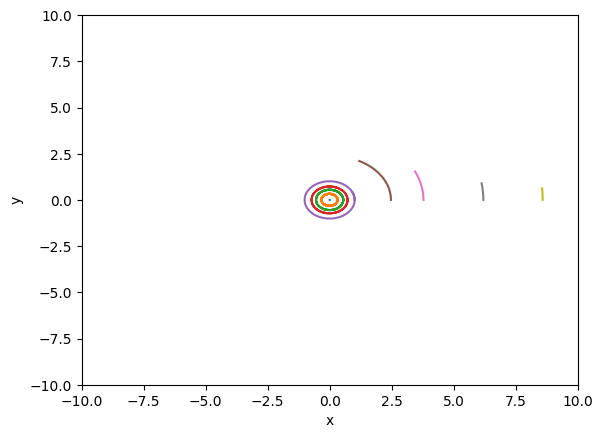

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set(xlim=[-10, 10], ylim=[-10, 10], xlabel='x', ylabel='y')
lines = []
for i, planet in enumerate(bodies.keys()):
#lines = np.array((1,10,2))
    lines.append(ax.plot(trajectories_copy[0,i,0], trajectories_copy[0,i,1])[0])

def update(frame):
    for i, planet in enumerate(bodies.keys()):
        last_value = min(frame, 200*i**2)
        _x = trajectories_copy[:last_value, i, 0]
        lines[i].set_xdata(_x)
        lines[i].set_ydata(trajectories_copy[:last_value, i, 1])
    return lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=30)
ani.save("animation.gif", writer="pillow")
plt.show()

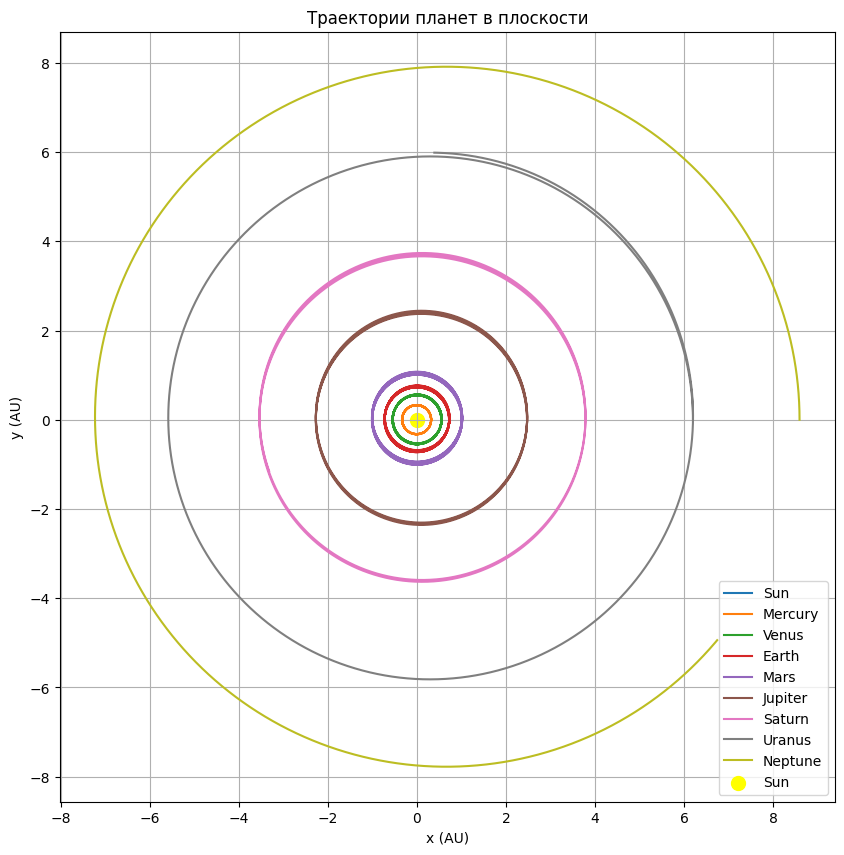

In [14]:
# Визуализация
plt.figure(figsize=(10, 10))
for i, planet in enumerate(bodies.keys()):
    plt.plot(trajectories_copy[:200*i**2, i, 0], trajectories_copy[:200*i**2, i, 1], label=planet)

plt.scatter(0, 0, color='yellow', s=100, label="Sun")
plt.legend()
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Траектории планет в плоскости")
plt.grid()
plt.show()